## 作业四

作业四是对seq2seq模型的一个有趣的应用。Seq2seq模型可以用学习从序列到序列的转换，而序列到序列转换的任务有很多。在作业四里，使用seq2seq模型来学习两位整数的加减法。虽然使用计算机进行数值计算是很容易的任务，但是如果让计算机以“自然语言处理”的方式来计算则很有挑战性。加减法的算式可以视为一个输入文本，如`'1+99'`，而结果也可以视为一个输出文本，例如`'100'`。我们希望模型可以对输入的算式字符串，输出结果的字符串。在这里，输入与输出都有可变的长度，且都具有时序特征，适合使用seq2seq模型。

针对上面的需求，实验的框架为：
1. 生成算式作为语料。包括：
    * 遍历生成用于计算的数字、符号及对应的结果。
    * 算式等号左边与右边的内容分别转成文本。
    * 对不同长度的文本，补齐到最大长度。
    * 以文本中所涉及的符号得到词典。
    * 应用此词典把输入、输出序列中的符号转为token。


2. 将此语料整理为seq2seq模型可使用的数据。
    * 将语料样本集包装为`Dataloader`对象，其在训练过程中提供`batch`的数据。


3. 对模型进行训练并测试。

作业以补全代码形式完成。我们使用第14周课上的包来实现，因此需将数据集处理为与其兼容的形式。我们通过定义类`DataGen`来生成数据。需补全的代码也主要在这一部分。

* `self.vocab`包含算式里所有可能出现的字符，为Vocab对象，其作用为将输入的tokens转为对应的编号。例如将 `['1', '+', '1']` 转换为 `[6, 3, 6]` 。Vocab对象具有`idx_to_token`与`token_to_idx`属性。`idx_to_token`与`token_to_idx`都是字典类型，`idx_to_token`的key是每个字符的序号，value是每个字符；`token_to_idx`的key是每个字符，value是每个字符的序号。**这里需要补全代码**。

* 在`DataGen`的`generate()`函数中，首先遍历生成加减法的样本集，得到用于计算的数据、符号（'+'或者'-'）与结果。

* 调用`equation_to_text()`函数，将生成的算式转为文本。

* 在`text_to_token()`函数中，为每个式子末尾加上`'<eos>'`；并且由于每个式子的长度不同，需将句子末尾使用`'<pad>'`符号来填充。**这里需要补全代码**。

* 最后将转为字符序列的样本转换为`tensor`，并使用torch本身的`TensorDataset``DataLoader`来得到数据的加载器`loader`作为数据集生成的结果，作为`DataGen.generate()`函数返回结果。

* 调用`tran_calculator()`和`predict_calculator()`进行训练和预测。这两个函数都已在`nets.py`中实现，注意先将模块导入。**这里需要补全代码**。

In [1]:
import numpy as np
import torch
import os
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from d2l import torch as d2l
from nets import Seq2SeqEncoder, Seq2SeqDecoder
'''
从nets模块中导入模型训练的函数 train_calculator 和测试的函数 predict_calculator
##########
'''
from nets import train_calculator, predict_calculator

class Vocab(object):
    def __init__(self, symbols):        
        '''
        Vocab对象具有 idx_to_token 与 token_to_idx 属性。
        idx_to_token 与 token_to_idx 都是字典类型。
        idx_to_token 的 key 是每个字符的序号，value 是每个字符；
        token_to_idx 的 key 是每个字符，value 是每个字符的序号。
        其作用是把 token 与对应的编号相互转换，例如将 ['1', '+', '1'] 转换为 `[6, 3, 6]` 。
        
        self.idx_to_token = ##########{1:'+', 2:'-', ... }
        self.token_to_idx = ##########  {'+':1, '-':2, ... }
        '''
        self.token_to_idx = {token: idx for idx, token in enumerate(symbols)}
        self.idx_to_token = {idx: token for idx, token in enumerate(symbols)}
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, 'unknown')
        return [self.__getitem__(token) for token in tokens]
    

class DataGen(object):
    def __init__(self, digits):
        # __init__()的参数为数字的位数，这里取2。
        self.digits = digits 
        # 输入式子最大长度
        self.in_steps = digits * 2 + 3 
        # 输出式子最大长度
        self.out_steps = digits + 3 
        # 计算用到的所有符号
        symbols = ['<pad>','<bos>','<eos>','+','-'] + [str(i) for i in range(10)] 
        self.vocab = Vocab(symbols)     
    
    def equation_to_text(self, data, sign, result):
        # 所有的算式为 a+b=c 或者 a-b=c，等号左边为输入序列，等号右边为输出序列。
        t1 = [str(a) for a in data[:, 0]]
        t2 = ['+' if s == 1 else '-' for s in sign]
        t3 = [str(b) for b in data[:, 1]]
        t4 = [str(c) for c in result]
        left_text = [''.join(t) for t in list(zip(t1, t2, t3))]
        right_text = [str(c) for c in result]
        
        return left_text, right_text
        
    def text_to_token(self, left_text, right_text):
        # 为文本补全<eos>与<pad>到固定长度
        left = [''.join(t) for t in left_text]
        left = [[l for l in t] + ['<eos>'] for t in left]
        left_len = [len(line) for line in left]
        '''
        为每个输入式子结尾补全'<pad>'，使得总长度为self.in_steps
        
        left = ##########
        '''
        left = [line + ['<pad>'] * (self.in_steps - len(line)) for line in left]
        
        right = [[l for l in t] + ['<eos>'] for t in right_text]
        right_len = [len(line) for line in right]
        '''
        为每个输出式子结尾补全'<pad>'，使得总长度为self.out_steps
        
        right = ##########
        '''
        right = [line + ['<pad>'] * (self.out_steps - len(line)) for line in right]
        
        # 字符转换为词表索引序号
        token_left = [self.vocab[line] for line in left]
        token_left_len = left_len
        token_right = [self.vocab[line] for line in right]
        token_right_len = right_len
        return token_left, token_left_len, token_right, token_right_len

        
    def generate(self, batch_size): 
        # 遍历生成两个数字计算加减法
        x = np.linspace(0, 99, 100, dtype=int)
        y = np.linspace(0, 99, 100, dtype=int)
        X, Y = np.meshgrid(x, y)
        data = np.stack((X, Y), axis=-1).reshape(-1, 2)
        data = np.tile(data, [2, 1])
        
        # 指定加减法
        sign = [-1] * 10000 + [1] * 10000 
        sign = np.array(sign)
        # 得到结果
        result = data[:, 0] + sign * data[:, 1]
        
        '''
        调用equation_to_text()函数，把上面生成的算式转成文本
        
        left_text, right_text = ##########
        left_text 的形式为 ['0-0', '1-0', '2-0', '3-0', '4-0', '5-0', '6-0', '7-0', '8-0', '9-0', '10-0',...]
        right_text 的形式为 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ...]
        
        '''
        left_text, right_text = self.equation_to_text(data, sign, result)
        
        # 将文本语料氛围训练集与测试集
        left_train, left_test, right_train, right_test = \
            train_test_split(left_text, right_text, test_size=0.2, random_state=2023)
        
        # 文本转换为token序列
        token_left, token_left_len, token_right, token_right_len = self.text_to_token(left_train, right_train)
        # 转为 tensor
        data_arrays = [torch.tensor(i) \
                       for i in [token_left, token_left_len, token_right, token_right_len]]
        dataset = TensorDataset(*data_arrays)
        # 得到训练与测试的 DataLoader 对象
        loader_train = DataLoader(dataset, batch_size, shuffle=True, )
        loader_test = DataLoader(left_test, 10, shuffle=True, )
        
        return loader_train, loader_test, self.vocab, self.vocab

84+60 => 144
30+70 => 100
65+13 => 79
90-55 => 34
56+42 => 98
26+38 => 64
74-80 => -6
75-43 => 32
14-30 => -16
30-83 => -63


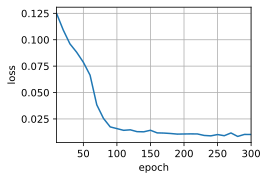

In [2]:
# 设置超参数
embed_size, num_hiddens, num_layers, dropout = 16, 64, 2, 0.1
batch_size, num_steps = 256, 7
lr, num_epochs, device = 0.01, 300, d2l.try_gpu()

# 实例化 DataGen 对象，参数为数字的位数，这里取2。
gen = DataGen(2) 
# 训练数据集自动取出 batch 数据
loader_train, loader_test, src_vocab, tgt_vocab = gen.generate(batch_size)

# 实例化 seq2seq 的 encoder
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
# 实例化 seq2seq 的 decoder
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
# 实例化一个seq2seq模型 
net = d2l.EncoderDecoder(encoder, decoder) 

# 如果有预训练的模型文件，则加载模型文件
if os.path.exists('./net.pth'):  
    net.load_state_dict(torch.load('./net.pth'))
    
# 训练模型
train_calculator(net, loader_train, lr, num_epochs, tgt_vocab, device)
# 保存模型
torch.save(net.state_dict(), 'net.pth') 

# 测试模型
left_bacth = next(iter(loader_test))
for left in left_bacth:
    result = predict_calculator(
        net, left, src_vocab, tgt_vocab, num_steps, device)
    print(f'{left} => {result}')
